In [1]:
import sys
sys.path.insert(0, '../')
import ccob_qe_analysis as qe
import ccob_utils as u
import os
import glob
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle as pkl
import ccob_beam as beam

In [42]:
#config = u.load_ccob_config("../ccob_config_9rafts.yaml")
config = u.load_ccob_config("../beam_config.yaml")
#config = {}

#### Choose the LED used to reconstruct the beam among [nm960, nm850, nm750, red, blue, uv]

In [44]:
#config['tmp_dir']='/home/combet/tmp_MR/60x60/'
#config['led_name']='nm850'
config['tmpdir'] = '/home/combet/tmp'
config

{'led_name': 'red',
 'rootdir': '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/',
 'rundir': ['/6840D/BOT_acq/v0/48024/'],
 'scan_size': 12,
 'tmpdir': '/home/combet/tmp',
 'ref_raft': 'R22',
 'ref_slot': 'S11',
 'ref_amps': [4, 5],
 'ref_pix_x': 1000,
 'ref_pix_y': 256,
 'npix_for_avg': 30,
 'ref_amp': 5,
 'path': './',
 'current': '*',
 'exp_time': '*',
 'xpos': '*',
 'ypos': '*',
 'slot': '*'}

In [10]:
## Path to the data. Here 6593D is the run number.
## R22, baffle off
# ref_raft = 'R22' # raft  
# ref_slot = 'S11' # ccd in ref_raft to use for the beam reconstruction (we'll use a buch of pixels in each amp of that CCD)
# baffle = 'off'
# dirlist=glob.glob('/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6680D/BOT_acq/v0/46569/ccob_'+config['led_name']+'*')

# R22, baffle on
ref_raft = 'R22' # raft  
ref_slot = 'S11' # ccd in ref_raft to use for the beam reconstruction (we'll use a buch of pixels in each amp of that CCD)
baffle = 'on'
#dirlist1=glob.glob('/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6681D/BOT_acq/v0/46576/ccob_'+config['led_name']+'*')
#dirlist2=glob.glob('/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6682D/BOT_acq/v0/46581/ccob_'+config['led_name']+'*')
#dirlist = glob.glob('/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6840D/BOT_acq/v0/48024/ccob_'+config['led_name']+'*')

dirlist1 = glob.glob('/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6845D/BOT_acq/v0/48057/ccob_'+config['led_name']+'*')
dirlist2 = glob.glob('/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6845D/BOT_acq/v0/48073/ccob_'+config['led_name']+'*')
dirlist3 = glob.glob('/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6855D/BOT_acq/v0/48130/ccob_'+config['led_name']+'*')
dirlist=sorted(dirlist1+dirlist2)#+dirlist3)
#dirlist = glob.glob('/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6856D/BOT_acq/v0/48135/ccob_'+config['led_name']+'*')

# R10, baffle off
# ref_raft = 'R10' # raft  
# ref_slot = 'S20' # ccd in ref_raft to use for the beam reconstruction (we'll use a buch of pixels in each amp of that CCD)
# baffle = 'off'
# dirlist=glob.glob('/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6678D/BOT_acq/v0/46557/ccob_'+config['led_name']+'*')

# R10, baffle on
# ref_raft = 'R10' # raft  
# ref_slot = 'S11' # ccd in ref_raft to use for the beam reconstruction (we'll use a buch of pixels in each amp of that CCD)
# baffle = 'on'
# dirlist=glob.glob('/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6683D/BOT_acq/v0/46587/ccob_'+config['led_name']+'*')

In [11]:
print(len(dirlist))
print(dirlist[0])

2723
/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6845D/BOT_acq/v0/48057/ccob_red_-0.154_-0.825_4041


### Fill in beam object with raw data, using the central bunch of pixels in each channel

- ref_raft: 'R22' (central raft)
- ref_ccd: from S00 to S22 (S11 is the central CCD of the raft). Choose the CCD where the centre of the scan is located

In [6]:
config = {}

#### 12 x 12 scan

In [22]:
#config['tmp_dir']='/home/combet/tmp_9rafts/12x12/'
b = beam.CcobBeam(config)

for i in np.arange(12): # that's just to allow saving the data at intermediate steps for the 12x12 scan
    start = i*12
    end = (i+1)*12
    b.read_multibunch(config, dirlist=dirlist[start:end])#, outdir = config['tmp_dir'], ref_raft=ref_raft, ref_slot=ref_slot)    b.save(os.path.join(config['tmpdir'],'beam_object_'+ref_raft+'_'+ref_slot+'_'+b.config['led_name']+'_'+baffle+'.pkl'))

5 -0.154 -0.2 -0.825 -0.8 63657.605
5 -0.154 -0.2 -10.316 -10.3 63576.375
5 -0.154 -0.2 -11.672 -11.7 63551.27
5 -0.154 -0.2 -13.028 -13.0 63502.95
5 -0.154 -0.2 -14.384 -14.4 63443.2
5 -0.154 -0.2 -15.74 -15.7 63375.504
5 -0.154 -0.2 -17.096 -17.1 63323.086
5 -0.154 -0.2 -18.452 -18.5 63224.31
5 -0.154 -0.2 -19.808 -19.8 63132.312
5 -0.154 -0.2 -2.181 -2.2 63649.1
5 -0.154 -0.2 -21.164 -21.2 62990.996
5 -0.154 -0.2 -22.52 -22.5 62751.746
5 -0.154 -0.2 -23.876 -23.9 62432.95
5 -0.154 -0.2 -25.232 -25.2 61990.71
5 -0.154 -0.2 -26.588 -26.6 61497.156
5 -0.154 -0.2 -27.943 -27.9 60958.49
5 -0.154 -0.2 -29.299 -29.3 60385.227
5 -0.154 -0.2 -3.537 -3.5 63665.76
5 -0.154 -0.2 -30.655 -30.7 59758.9
5 -0.154 -0.2 -32.011 -32.0 59080.656
5 -0.154 -0.2 -33.367 -33.4 58366.39
5 -0.154 -0.2 -34.723 -34.7 57639.31
5 -0.154 -0.2 -36.079 -36.1 56870.645
5 -0.154 -0.2 -37.435 -37.4 56079.066
5 -0.154 -0.2 -4.893 -4.9 63670.332
5 -0.154 -0.2 -6.249 -6.2 63664.934
5 -0.154 -0.2 -7.604 -7.6 63650.42
5 -0

In [50]:
b.raw_data['xarr']

[-11.002,
 -11.002,
 -11.002,
 -11.002,
 -11.002,
 -11.002,
 -11.002,
 -11.002,
 -11.002,
 -11.002,
 -11.002,
 -11.002,
 -11.002,
 -11.002,
 -11.002,
 -11.002,
 -11.002,
 -11.002,
 -11.002,
 -11.002,
 -11.002,
 -11.002,
 -11.002,
 -11.002,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -1.51,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 -0.154,
 

#### 60 x 60 scan

In [6]:
config['led_name']

'uv'

In [8]:
config['tmp_dir']='/home/combet/tmp_9rafts/60x60/'
#config['led_name']='red'
b = beam.CcobBeam(config)
#b = pkl.load(open(os.path.join(config['tmp_dir'],
#                               'beam_object_'+ref_raft+'_'+ref_slot+'_'+config['led_name']+'_'+baffle+'.pkl'),'rb'))
for i in np.arange(60): # that's just to allow saving the data at intermediate steps for the 60x60 scan
    print(i)
    start = i*60
    end = (i+1)*60
    b.read_multibunch(dirlist=dirlist[start:end], outdir = config['tmp_dir'], ref_raft=ref_raft, ref_slot=ref_slot)
    b.save(os.path.join(config['tmp_dir'],'beam_object_'+ref_raft+'_'+ref_slot+'_'+b.config['led_name']+'_'+baffle+'.pkl'))

0
16 -0.154 -0.2 41.209 41.2 42256.523
16 -11.002 -11.0 -6.249 -6.2 79533.78
16 -12.358 -12.4 -10.316 -10.3 79840.93
16 -12.358 -12.4 -18.452 -18.5 80334.1
16 -12.358 -12.4 -26.588 -26.6 80440.875
16 -12.358 -12.4 42.565 42.6 40822.375
16 -16.426 -16.4 -3.537 -3.5 78285.38
16 -16.426 -16.4 26.294 26.3 54986.49
16 -17.782 -17.8 20.87 20.9 59564.117
16 -20.493 -20.5 -33.367 -33.4 79644.36
16 -20.493 -20.5 0.531 0.5 74757.234
16 -20.493 -20.5 16.802 16.8 62332.96
16 -20.493 -20.5 31.718 31.7 49142.46
16 -23.205 -23.2 -4.893 -4.9 76610.78
16 -23.205 -23.2 11.379 11.4 65860.46
16 -23.205 -23.2 12.734 12.7 64759.91
16 -24.561 -24.6 19.514 19.5 58584.24
16 -25.917 -25.9 -29.299 -29.3 79225.88
16 -28.629 -28.6 -27.943 -27.9 78412.305
16 -4.222 -4.2 -34.723 -34.7 80356.04
16 -6.934 -6.9 -30.655 -30.7 80540.7
16 -8.29 -8.3 -7.604 -7.6 79781.5
16 -9.646 -9.7 37.141 37.1 45969.945
16 13.405 13.4 3.243 3.2 72091.78
16 14.761 14.8 -34.723 -34.7 79186.266
16 16.117 16.1 0.531 0.5 72551.67
16 2.557 2.

16 31.032 31.0 -32.011 -32.0 69634.99
16 32.388 32.4 16.802 16.8 51723.48
16 33.744 33.7 -0.825 -0.8 61437.945
16 33.744 33.7 -13.028 -13.0 66134.88
16 33.744 33.7 -37.435 -37.4 66183.336
16 33.744 33.7 22.226 22.2 47053.965
16 36.456 36.4 -27.943 -27.9 65374.836
16 36.456 36.4 33.073 33.1 37825.02
16 37.812 37.8 -13.028 -13.0 62652.605
16 40.523 40.5 24.938 24.9 41224.312
16 41.879 41.9 -8.96 -9.0 57971.086
16 41.879 41.9 12.734 12.7 48005.11
16 41.879 41.9 27.65 27.7 38621.67
16 43.235 43.2 42.565 42.6 28057.146
16 44.591 44.6 19.514 19.5 42093.535
16 48.659 48.6 18.158 18.2 40123.965
16 48.659 48.6 39.853 39.9 27188.725
16 48.659 48.6 42.565 42.6 25514.404
16 50.015 50.0 -34.723 -34.7 52210.992
16 50.015 50.0 41.209 41.2 25688.053
4
16 -0.154 -0.2 -4.893 -4.9 79461.57
16 -11.002 -11.0 18.158 18.2 63324.06
16 -12.358 -12.4 -22.52 -22.5 80419.78
16 -13.714 -13.7 22.226 22.2 59228.168
16 -13.714 -13.7 8.667 8.7 71066.62
16 -15.07 -15.1 12.734 12.7 67359.45
16 -15.07 -15.1 5.955 6.0 728

16 -28.629 -28.6 -4.893 -4.9 73810.93
16 -4.222 -4.2 -26.588 -26.6 80621.6
16 -4.222 -4.2 19.514 19.5 62522.062
16 -4.222 -4.2 39.853 39.9 43655.426
16 -5.578 -5.6 34.429 34.4 48624.387
16 -8.29 -8.3 34.429 34.4 48560.664
16 1.201 1.2 19.514 19.5 62150.934
16 1.201 1.2 39.853 39.9 43398.29
16 14.761 14.8 18.158 18.2 59819.938
16 2.557 2.6 -10.316 -10.3 79894.62
16 2.557 2.6 -19.808 -19.8 80422.56
16 20.184 20.2 24.938 24.9 51927.09
16 21.54 21.5 1.887 1.9 68682.7
16 22.896 22.9 -10.316 -10.3 73880.81
16 22.896 22.9 33.073 33.1 44066.137
16 25.608 25.6 38.497 38.5 38601.746
16 26.964 27.0 -29.299 -29.3 73377.72
16 28.32 28.3 -23.876 -23.9 72458.375
16 28.32 28.3 41.209 41.2 35401.707
16 29.676 29.7 8.667 8.7 58975.17
16 3.913 3.9 -37.435 -37.4 79960.766
16 33.744 33.7 -11.672 -11.7 65768.75
16 33.744 33.7 -6.249 -6.2 63872.223
16 35.1 35.1 -30.655 -30.7 66305.75
16 35.1 35.1 -7.604 -7.6 63241.82
16 35.1 35.1 1.887 1.9 59013.16
16 37.812 37.8 1.887 1.9 56911.895
16 39.168 39.2 12.734 12.

16 -19.138 -19.1 -14.384 -14.4 79698.26
16 -19.138 -19.1 33.073 33.1 48274.367
16 -2.866 -2.9 -2.181 -2.2 78974.586
16 -2.866 -2.9 30.362 30.4 52387.7
16 -2.866 -2.9 37.141 37.1 46106.32
16 -20.493 -20.5 4.599 4.6 72085.37
16 -21.849 -21.9 -25.232 -25.2 79778.37
16 -21.849 -21.9 26.294 26.3 53589.832
16 -24.561 -24.6 27.65 27.7 51568.55
16 -24.561 -24.6 7.311 7.3 68392.055
16 -25.917 -25.9 14.09 14.1 62500.14
16 -25.917 -25.9 4.599 4.6 69682.586
16 -6.934 -6.9 -19.808 -19.8 80599.164
16 -8.29 -8.3 15.446 15.4 66076.65
16 -9.646 -9.7 -10.316 -10.3 79962.37
16 -9.646 -9.7 41.209 41.2 42254.074
16 1.201 1.2 37.141 37.1 45859.465
16 10.693 10.7 26.294 26.3 54038.523
16 13.405 13.4 15.446 15.4 62622.75
16 13.405 13.4 30.362 30.4 49652.383
16 16.117 16.1 10.023 10.0 65871.164
16 18.829 18.8 -34.723 -34.7 77914.32
16 18.829 18.8 42.565 42.6 37587.723
16 2.557 2.6 -7.604 -7.6 79650.13
16 20.184 20.2 -23.876 -23.9 78083.48
16 21.54 21.5 26.294 26.3 50234.734
16 24.252 24.2 3.243 3.2 66119.81
16

16 37.812 37.8 -23.876 -23.9 64194.254
16 37.812 37.8 -33.367 -33.4 63542.586
16 37.812 37.8 -8.96 -9.0 61452.11
16 39.168 39.2 -30.655 -30.7 62697.17
16 40.523 40.5 -34.723 -34.7 60882.54
16 43.235 43.2 -4.893 -4.9 55406.75
16 43.235 43.2 23.582 23.6 40418.586
16 44.591 44.6 -10.316 -10.3 55922.992
16 45.947 45.9 -11.672 -11.7 55086.78
16 47.303 47.3 14.09 14.1 43324.363
16 47.303 47.3 29.006 29.0 34580.28
16 50.015 50.0 -26.588 -26.6 52936.605
16 7.981 8.0 -0.825 -0.8 76710.45
15
16 -0.154 -0.2 -37.435 -37.4 80110.51
16 -0.154 -0.2 19.514 19.5 62294.703
16 -1.51 -1.5 19.514 19.5 62417.027
16 -11.002 -11.0 -26.588 -26.6 80493.41
16 -13.714 -13.7 -37.435 -37.4 79959.84
16 -13.714 -13.7 19.514 19.5 61700.17
16 -16.426 -16.4 14.09 14.1 65900.93
16 -19.138 -19.1 -33.367 -33.4 79777.64
16 -19.138 -19.1 39.853 39.9 42253.05
16 -2.866 -2.9 -17.096 -17.1 80491.29
16 -2.866 -2.9 20.87 20.9 61220.816
16 -20.493 -20.5 -0.825 -0.8 75562.19
16 -20.493 -20.5 -37.435 -37.4 79418.4
16 -20.493 -20.5 1

16 2.557 2.6 16.802 16.8 64413.777
16 21.54 21.5 -22.52 -22.5 77277.14
16 22.896 22.9 -2.181 -2.2 70194.37
16 24.252 24.2 -15.74 -15.7 74522.17
16 24.252 24.2 11.379 11.4 60576.55
16 25.608 25.6 29.006 29.0 46218.12
16 28.32 28.3 -29.299 -29.3 72268.14
16 29.676 29.7 22.226 22.2 49395.26
16 3.913 3.9 11.379 11.4 68931.4
16 33.744 33.7 -15.74 -15.7 66805.7
16 33.744 33.7 -34.723 -34.7 66814.37
16 33.744 33.7 11.379 11.4 54452.387
16 36.456 36.4 -33.367 -33.4 64716.535
16 37.812 37.8 -3.537 -3.5 59449.008
16 39.168 39.2 -13.028 -13.0 61458.67
16 40.523 40.5 20.87 20.9 43890.445
16 41.879 41.9 -33.367 -33.4 59895.38
16 43.235 43.2 -18.452 -18.5 58817.375
16 43.235 43.2 15.446 15.4 45423.734
16 44.591 44.6 14.09 14.1 45271.58
16 45.947 45.9 14.09 14.1 44281.49
16 48.659 48.6 -11.672 -11.7 52641.406
16 48.659 48.6 1.887 1.9 48199.785
16 5.269 5.3 -29.299 -29.3 80295.555
16 5.269 5.3 -4.893 -4.9 79087.875
16 5.269 5.3 11.379 11.4 68601.09
16 5.269 5.3 38.497 38.5 44130.457
16 6.625 6.6 -14.3

16 -23.205 -23.2 -37.435 -37.4 79129.87
16 -24.561 -24.6 -0.825 -0.8 73828.766
16 -24.561 -24.6 0.531 0.5 73014.71
16 -25.917 -25.9 -11.672 -11.7 77908.54
16 -28.629 -28.6 -2.181 -2.2 72394.92
16 -4.222 -4.2 33.073 33.1 49892.81
16 -6.934 -6.9 5.955 6.0 74131.96
16 -8.29 -8.3 -0.825 -0.8 78374.81
16 -9.646 -9.7 -19.808 -19.8 80487.25
16 -9.646 -9.7 -2.181 -2.2 78834.76
16 -9.646 -9.7 7.311 7.3 72868.664
16 1.201 1.2 12.734 12.7 68233.01
16 1.201 1.2 30.362 30.4 52109.164
16 10.693 10.7 -14.384 -14.4 79608.56
16 10.693 10.7 16.802 16.8 62418.977
16 12.049 12.0 -15.74 -15.7 79549.3
16 14.761 14.8 34.429 34.4 45697.363
16 17.473 17.5 -26.588 -26.6 79078.45
16 17.473 17.5 39.853 39.9 40259.875
16 21.54 21.5 8.667 8.7 64109.324
16 22.896 22.9 -11.672 -11.7 74354.05
16 22.896 22.9 -32.011 -32.0 76004.06
16 22.896 22.9 -33.367 -33.4 75758.79
16 25.608 25.6 39.853 39.9 37518.215
16 28.32 28.3 -36.079 -36.1 71071.54
16 29.676 29.7 35.785 35.8 39013.06
16 3.913 3.9 -36.079 -36.1 80041.94
16 31.0

16 45.947 45.9 -15.74 -15.7 55925.516
16 45.947 45.9 41.209 41.2 27649.604
16 47.303 47.3 34.429 34.4 31232.658
16 5.269 5.3 20.87 20.9 60216.074
16 50.015 50.0 0.531 0.5 47603.61
16 6.625 6.6 -15.74 -15.7 80012.71
16 7.981 8.0 11.379 11.4 67892.47
26
16 -1.51 -1.5 16.802 16.8 64889.41
16 -11.002 -11.0 -0.825 -0.8 78039.67
16 -11.002 -11.0 -36.079 -36.1 80134.32
16 -15.07 -15.1 -17.096 -17.1 80128.98
16 -15.07 -15.1 -3.537 -3.5 78556.58
16 -15.07 -15.1 -30.655 -30.7 80199.29
16 -15.07 -15.1 -7.604 -7.6 79458.02
16 -16.426 -16.4 -26.588 -26.6 80233.16
16 -16.426 -16.4 -30.655 -30.7 80143.484
16 -16.426 -16.4 18.158 18.2 62300.64
16 -19.138 -19.1 -7.604 -7.6 79024.34
16 -2.866 -2.9 23.582 23.6 58706.703
16 -21.849 -21.9 0.531 0.5 74250.11
16 -23.205 -23.2 -19.808 -19.8 79546.22
16 -28.629 -28.6 -22.52 -22.5 78388.01
16 -29.985 -30.0 12.734 12.7 61566.496
16 -4.222 -4.2 16.802 16.8 64992.57
16 -5.578 -5.6 10.023 10.0 70922.11
16 -5.578 -5.6 24.938 24.9 57479.383
16 -5.578 -5.6 29.006 29.0

16 31.032 31.0 -26.588 -26.6 70144.14
16 33.744 33.7 -32.011 -32.0 67317.91
16 33.744 33.7 -8.96 -9.0 64891.35
16 35.1 35.1 14.09 14.1 51802.72
16 35.1 35.1 5.955 6.0 56778.95
16 36.456 36.4 23.582 23.6 44543.914
16 36.456 36.4 31.718 31.7 38803.254
16 37.812 37.8 0.531 0.5 57603.066
16 39.168 39.2 -14.384 -14.4 61782.836
16 40.523 40.5 35.785 35.8 33895.797
16 40.523 40.5 41.209 41.2 30199.623
16 41.879 41.9 34.429 34.4 34102.234
16 44.591 44.6 41.209 41.2 28293.28
16 44.591 44.6 7.311 7.3 48910.574
16 45.947 45.9 30.362 30.4 34514.863
16 47.303 47.3 -17.096 -17.1 54915.54
16 47.303 47.3 7.311 7.3 46812.81
16 48.659 48.6 -2.181 -2.2 49800.992
16 50.015 50.0 24.938 24.9 35329.227
16 6.625 6.6 -25.232 -25.2 80229.875
16 6.625 6.6 -27.943 -27.9 80206.34
16 9.337 9.3 14.09 14.1 65191.832
30
16 -1.51 -1.5 10.023 10.0 70834.336
16 -11.002 -11.0 12.734 12.7 68132.59
16 -11.002 -11.0 29.006 29.0 53321.35
16 -12.358 -12.4 33.073 33.1 49423.75
16 -13.714 -13.7 -17.096 -17.1 80258.49
16 -13.714 

16 -6.934 -6.9 4.599 4.6 75110.99
16 -8.29 -8.3 -18.452 -18.5 80522.37
16 -9.646 -9.7 -13.028 -13.0 80161.266
16 -9.646 -9.7 34.429 34.4 48477.17
16 10.693 10.7 -30.655 -30.7 79804.625
16 12.049 12.0 -27.943 -27.9 79741.086
16 12.049 12.0 0.531 0.5 74435.055
16 16.117 16.1 11.379 11.4 64809.137
16 16.117 16.1 18.158 18.2 59277.82
16 16.117 16.1 22.226 22.2 55835.637
16 20.184 20.2 4.599 4.6 67728.555
16 21.54 21.5 -15.74 -15.7 76344.95
16 21.54 21.5 31.718 31.7 45728.207
16 24.252 24.2 -34.723 -34.7 74543.89
16 24.252 24.2 27.65 27.7 47924.71
16 25.608 25.6 0.531 0.5 66813.98
16 25.608 25.6 22.226 22.2 51606.613
16 26.964 27.0 14.09 14.1 56982.203
16 28.32 28.3 19.514 19.5 52188.266
16 29.676 29.7 -11.672 -11.7 69144.8
16 29.676 29.7 30.362 30.4 43202.344
16 3.913 3.9 -32.011 -32.0 80268.11
16 32.388 32.4 -26.588 -26.6 68956.76
16 32.388 32.4 -6.249 -6.2 64958.46
16 35.1 35.1 -17.096 -17.1 65882.125
16 36.456 36.4 0.531 0.5 58655.7
16 37.812 37.8 11.379 11.4 51664.24
16 39.168 39.2 23.

16 -1.51 -1.5 22.226 22.2 59894.72
16 -16.426 -16.4 15.446 15.4 64701.527
16 -19.138 -19.1 16.802 16.8 62750.375
16 -2.866 -2.9 -19.808 -19.8 80574.58
16 -20.493 -20.5 22.226 22.2 57596.934
16 -21.849 -21.9 12.734 12.7 65288.9
16 -23.205 -23.2 1.887 1.9 72810.055
16 -25.917 -25.9 0.531 0.5 72343.92
16 -25.917 -25.9 19.514 19.5 58051.613
16 -27.273 -27.3 30.362 30.4 48303.54
16 -28.629 -28.6 -19.808 -19.8 78180.21
16 -29.985 -30.0 -11.672 -11.7 75679.68
16 -29.985 -30.0 -4.893 -4.9 72959.61
16 -29.985 -30.0 10.023 10.0 63603.004
16 -29.985 -30.0 8.667 8.7 64603.254
16 -4.222 -4.2 -36.079 -36.1 80284.766
16 -4.222 -4.2 -7.604 -7.6 79802.81
16 -4.222 -4.2 5.955 6.0 74184.41
16 -8.29 -8.3 -34.723 -34.7 80326.28
16 -9.646 -9.7 -32.011 -32.0 80395.84
16 -9.646 -9.7 12.734 12.7 68339.484
16 13.405 13.4 -32.011 -32.0 79490.73
16 17.473 17.5 15.446 15.4 60971.086
16 17.473 17.5 18.158 18.2 58751.902
16 18.829 18.8 -29.299 -29.3 78588.64
16 2.557 2.6 33.073 33.1 49458.25
16 20.184 20.2 26.294 26

16 37.812 37.8 12.734 12.7 50846.496
16 37.812 37.8 8.667 8.7 53288.574
16 40.523 40.5 16.802 16.8 46481.992
16 45.947 45.9 -19.808 -19.8 56485.84
16 47.303 47.3 -7.604 -7.6 52781.574
16 47.303 47.3 0.531 0.5 49877.04
16 48.659 48.6 11.379 11.4 43744.96
16 48.659 48.6 26.294 26.3 35405.098
16 48.659 48.6 8.667 8.7 45101.49
16 50.015 50.0 1.887 1.9 47053.848
16 50.015 50.0 11.379 11.4 42707.332
16 50.015 50.0 37.141 37.1 28113.213
16 50.015 50.0 8.667 8.7 44031.137
16 6.625 6.6 -11.672 -11.7 79755.41
16 6.625 6.6 18.158 18.2 62378.25
41
16 -0.154 -0.2 -0.825 -0.8 78256.0
16 -1.51 -1.5 -11.672 -11.7 80130.51
16 -1.51 -1.5 -7.604 -7.6 79781.53
16 -1.51 -1.5 -8.96 -9.0 79897.03
16 -11.002 -11.0 35.785 35.8 47073.875
16 -16.426 -16.4 0.531 0.5 76159.125
16 -16.426 -16.4 1.887 1.9 75319.625
16 -16.426 -16.4 11.379 11.4 68197.28
16 -19.138 -19.1 -11.672 -11.7 79506.91
16 -20.493 -20.5 19.514 19.5 59970.516
16 -23.205 -23.2 -7.604 -7.6 77744.07
16 -25.917 -25.9 -33.367 -33.4 78956.81
16 -27.27

16 13.405 13.4 14.09 14.1 63755.59
16 16.117 16.1 26.294 26.3 52346.83
16 17.473 17.5 26.294 26.3 51865.11
16 18.829 18.8 -26.588 -26.6 78685.16
16 2.557 2.6 -14.384 -14.4 80193.54
16 2.557 2.6 3.243 3.2 75500.055
16 20.184 20.2 -4.893 -4.9 73313.664
16 20.184 20.2 27.65 27.7 49676.668
16 24.252 24.2 15.446 15.4 57562.57
16 24.252 24.2 20.87 20.9 53356.453
16 28.32 28.3 -8.96 -9.0 69319.16
16 28.32 28.3 34.429 34.4 40669.383
16 29.676 29.7 -21.164 -21.2 71129.13
16 3.913 3.9 1.887 1.9 76125.05
16 3.913 3.9 5.955 6.0 73309.03
16 31.032 31.0 -23.876 -23.9 70135.734
16 31.032 31.0 22.226 22.2 48608.773
16 32.388 32.4 -14.384 -14.4 67650.18
16 33.744 33.7 12.734 12.7 53566.33
16 35.1 35.1 -21.164 -21.2 66443.09
16 36.456 36.4 -8.96 -9.0 62616.902
16 36.456 36.4 12.734 12.7 51752.637
16 37.812 37.8 -2.181 -2.2 58861.703
16 37.812 37.8 -32.011 -32.0 63731.164
16 37.812 37.8 -4.893 -4.9 59985.137
16 39.168 39.2 -33.367 -33.4 62323.65
16 40.523 40.5 -0.825 -0.8 56060.062
16 40.523 40.5 4.599 4

16 -17.782 -17.8 -37.435 -37.4 79813.35
16 -19.138 -19.1 -26.588 -26.6 79983.18
16 -19.138 -19.1 31.718 31.7 49487.625
16 -20.493 -20.5 -23.876 -23.9 79844.12
16 -20.493 -20.5 -32.011 -32.0 79716.234
16 -25.917 -25.9 29.006 29.0 49946.246
16 -27.273 -27.3 20.87 20.9 56348.58
16 -29.985 -30.0 -0.825 -0.8 70808.91
16 -6.934 -6.9 -34.723 -34.7 80362.914
16 -6.934 -6.9 -6.249 -6.2 79656.875
16 -6.934 -6.9 16.802 16.8 64949.336
16 -6.934 -6.9 26.294 26.3 56184.36
16 10.693 10.7 34.429 34.4 46760.633
16 13.405 13.4 16.802 16.8 61471.645
16 13.405 13.4 22.226 22.2 56810.87
16 14.761 14.8 19.514 19.5 58665.29
16 14.761 14.8 38.497 38.5 42161.355
16 18.829 18.8 29.006 29.0 49039.277
16 20.184 20.2 -29.299 -29.3 77924.38
16 22.896 22.9 -27.943 -27.9 76421.47
16 22.896 22.9 3.243 3.2 66970.71
16 25.608 25.6 -10.316 -10.3 71920.89
16 28.32 28.3 -22.52 -22.5 72389.69
16 29.676 29.7 24.938 24.9 47357.574
16 29.676 29.7 39.853 39.9 35895.164
16 3.913 3.9 -2.181 -2.2 78377.38
16 3.913 3.9 -26.588 -26.

16 39.168 39.2 39.853 39.9 31751.818
16 41.879 41.9 -25.232 -25.2 60543.605
16 41.879 41.9 4.599 4.6 52409.973
16 43.235 43.2 -34.723 -34.7 58415.504
16 50.015 50.0 -29.299 -29.3 52825.652
16 50.015 50.0 19.514 19.5 38399.03
16 6.625 6.6 -19.808 -19.8 80169.81
52
16 -1.51 -1.5 5.955 6.0 74101.836
16 -12.358 -12.4 -27.943 -27.9 80438.88
16 -12.358 -12.4 14.09 14.1 66744.3
16 -13.714 -13.7 7.311 7.3 72139.38
16 -16.426 -16.4 -8.96 -9.0 79533.81
16 -23.205 -23.2 16.802 16.8 61399.45
16 -23.205 -23.2 5.955 6.0 69998.05
16 -24.561 -24.6 42.565 42.6 38689.2
16 -25.917 -25.9 -27.943 -27.9 79242.266
16 -28.629 -28.6 -3.537 -3.5 73135.41
16 -29.985 -30.0 -7.604 -7.6 74172.82
16 -29.985 -30.0 22.226 22.2 54000.68
16 -4.222 -4.2 0.531 0.5 77775.01
16 -5.578 -5.6 -4.893 -4.9 79530.13
16 -5.578 -5.6 38.497 38.5 44883.582
16 -6.934 -6.9 0.531 0.5 77729.02
16 -6.934 -6.9 1.887 1.9 76923.94
16 -8.29 -8.3 14.09 14.1 67287.78
16 -9.646 -9.7 -25.232 -25.2 80550.85
16 -9.646 -9.7 4.599 4.6 74857.125
16 13

16 17.473 17.5 31.718 31.7 47222.55
16 2.557 2.6 -25.232 -25.2 80495.445
16 20.184 20.2 30.362 30.4 47378.363
16 21.54 21.5 38.497 38.5 40098.72
16 25.608 25.6 -8.96 -9.0 71430.75
16 29.676 29.7 -4.893 -4.9 66554.47
16 3.913 3.9 0.531 0.5 76971.49
16 31.032 31.0 -11.672 -11.7 68009.22
16 32.388 32.4 -0.825 -0.8 62469.22
16 36.456 36.4 3.243 3.2 57263.766
16 39.168 39.2 0.531 0.5 56517.742
16 39.168 39.2 20.87 20.9 44740.293
16 40.523 40.5 -18.452 -18.5 61323.75
16 41.879 41.9 18.158 18.2 44728.406
16 41.879 41.9 29.006 29.0 37740.297
16 41.879 41.9 5.955 6.0 51726.78
16 43.235 43.2 -15.74 -15.7 58390.035
16 44.591 44.6 -19.808 -19.8 57742.027
16 47.303 47.3 10.023 10.0 45464.348
16 48.659 48.6 29.006 29.0 33776.574
16 5.269 5.3 -21.164 -21.2 80332.36
16 5.269 5.3 -37.435 -37.4 79885.11
16 50.015 50.0 -10.316 -10.3 51087.562
16 50.015 50.0 -30.655 -30.7 52721.332
16 6.625 6.6 -26.588 -26.6 80219.54
16 7.981 8.0 26.294 26.3 54719.707
56
16 -0.154 -0.2 0.531 0.5 77558.98
16 -1.51 -1.5 24.

16 -29.985 -30.0 41.209 41.2 38274.332
16 -5.578 -5.6 -7.604 -7.6 79814.86
16 -8.29 -8.3 -10.316 -10.3 80030.69
16 -9.646 -9.7 -4.893 -4.9 79466.79
16 -9.646 -9.7 22.226 22.2 59773.82
16 10.693 10.7 7.311 7.3 70231.88
16 10.693 10.7 8.667 8.7 69192.19
16 12.049 12.0 42.565 42.6 39299.76
16 13.405 13.4 -17.096 -17.1 79472.0
16 13.405 13.4 -21.164 -21.2 79601.6
16 14.761 14.8 -4.893 -4.9 76224.28
16 14.761 14.8 16.802 16.8 60957.137
16 17.473 17.5 -34.723 -34.7 78496.016
16 17.473 17.5 19.514 19.5 57620.066
16 18.829 18.8 -2.181 -2.2 72705.84
16 18.829 18.8 27.65 27.7 50188.54
16 18.829 18.8 35.785 35.8 43291.227
16 18.829 18.8 41.209 41.2 38714.22
16 20.184 20.2 -0.825 -0.8 71128.32
16 20.184 20.2 -30.655 -30.7 77803.81
16 20.184 20.2 35.785 35.8 42822.96
16 21.54 21.5 -34.723 -34.7 76354.72
16 22.896 22.9 7.311 7.3 64273.59
16 24.252 24.2 -2.181 -2.2 69254.75
16 25.608 25.6 34.429 34.4 41864.062
16 28.32 28.3 -11.672 -11.7 70253.01
16 28.32 28.3 -13.028 -13.0 70687.18
16 29.676 29.7 -1

In [ ]:
# print(b.raw_data['xarr'][135],b.raw_data['yarr'][135],b.raw_data['val'][12][135])

### Load the beam object created above...

In [1]:
import pickle as pkl
#ref_raft='R10'
#ref_slot='S10'
ref_raft = config['ref_raft']
ref_slot = config['ref_slot']
baffle='on'
# #led = b.config['led_name']
led = config['led_name']
# config['tmp_dir']='/home/combet/tmp_9rafts/60x60/'
bb = pkl.load(open(config['tmpdir']+'/beam_object_'+ref_raft+'_'
                   +ref_slot+'_'+led+'.pkl','rb'))

NameError: name 'config' is not defined

In [56]:
config['tmpdir']

'/home/combet/tmp'

### ... and plot the raw beam reconstruction

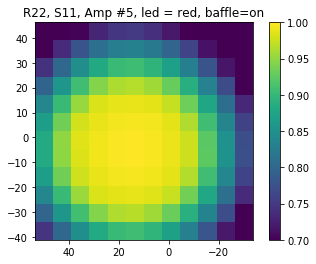

In [58]:
amp=5 # 1-16, select the channel used for the reconstruction. 5 = Segment14

binsize = (max(bb.raw_data['yarr'])-min(bb.raw_data['yarr']))/(config['scan_size']-1)
extent = [max(bb.raw_data['xarr'])+binsize/2,
          min(bb.raw_data['xarr'])-binsize/2,
          min(bb.raw_data['yarr'])-binsize/2, 
          max(bb.raw_data['yarr'])+binsize/2]

tmp1 = np.asarray(bb.raw_data['val'][amp])/np.asarray(bb.raw_data['pd_value']) # correct for the control photodiode value
tmp2 = tmp1 / max(tmp1) # normalise to the max

plt.imshow(np.flip(np.reshape(tmp1,(config['scan_size'],config['scan_size'])).T,axis=1), extent=extent, origin='lower', vmin=0.7)
plt.title(ref_raft+', '+ref_slot+', Amp #'+str(amp)+', led = '+led+', baffle='+baffle)
#plt.colorbar()
basename = ref_raft+'_'+ref_slot+'_'+str(amp)+'_'+baffle
plt.savefig(config['tmpdir']+'/beam_'+basename+'_'+led+'.png')

plt.imshow(np.flip(np.reshape(tmp2,(config['scan_size'],config['scan_size'])).T,axis=1), extent=extent, origin='lower', vmin=0.7)
plt.title(ref_raft+', '+ref_slot+', Amp #'+str(amp)+', led = '+led+', baffle='+baffle)
plt.colorbar()
basename = ref_raft+'_'+ref_slot+'_'+str(amp)+'_'+baffle
plt.savefig(config['tmpdir']+'/beam_'+basename+'_'+led+'_norm.png')



In [41]:
config['scan_size']

12

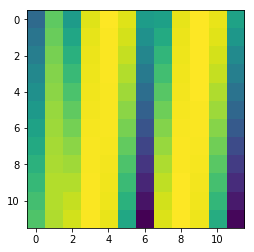

In [40]:
plt.imshow(np.reshape(tmp1,(config['scan_size'],config['scan_size'])).T)

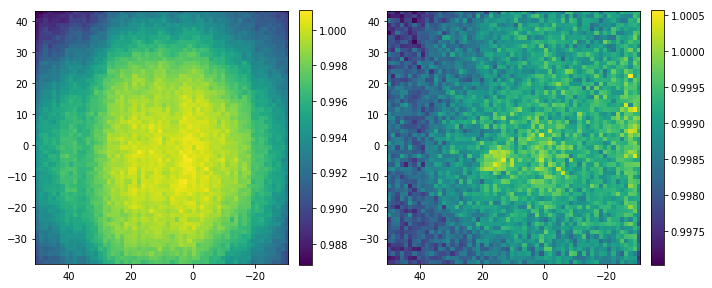

In [119]:
amp=5 # 1-16, select the channel used for the reconstruction. 5 = Segment14


led = 'red'
config['tmp_dir']='/home/combet/tmp_9rafts/60x60/'
bb = pkl.load(open(config['tmp_dir']+'/beam_object_'+ref_raft+'_'+ref_slot+'_'+led+'_'+baffle+'.pkl','rb'))
tmp_red = np.asarray(bb.raw_data['val'][amp])/np.asarray(bb.raw_data['pd_value']) # correct for the control photodiode value
tmp_red = tmp_red/max(tmp_red)

led = 'uv'
config['tmp_dir']='/home/combet/tmp_9rafts/60x60/'
bb = pkl.load(open(config['tmp_dir']+'/beam_object_'+ref_raft+'_'+ref_slot+'_'+led+'_'+baffle+'.pkl','rb'))
tmp_uv = np.asarray(bb.raw_data['val'][amp])/np.asarray(bb.raw_data['pd_value']) # correct for the control photodiode value
tmp_uv = tmp_uv/max(tmp_uv)

led = 'nm960'
config['tmp_dir']='/home/combet/tmp_9rafts/60x60/'
bb = pkl.load(open(config['tmp_dir']+'/beam_object_'+ref_raft+'_'+ref_slot+'_'+led+'_'+baffle+'.pkl','rb'))
tmp_nm960 = np.asarray(bb.raw_data['val'][amp])/np.asarray(bb.raw_data['pd_value']) # correct for the control photodiode value
tmp_nm960 = tmp_nm960/max(tmp_nm960)

#r1 = np.abs((tmp_red-tmp_uv)/tmp_red)
#r2 = np.abs((tmp_red-tmp_nm960)/tmp_red)
r1 = tmp_uv/tmp_red
r2 = tmp_nm960/tmp_red

binsize = (max(bb.raw_data['yarr'])-min(bb.raw_data['yarr']))/59
extent = [max(bb.raw_data['xarr'])+binsize/2,
          min(bb.raw_data['xarr'])-binsize/2,
          min(bb.raw_data['yarr'])-binsize/2, 
          max(bb.raw_data['yarr'])+binsize/2]

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
im0 = axes[0].imshow(np.flip(np.reshape(r1,(60,60)).T,axis=1), extent=extent, origin='lower')
basename = ref_raft+'_'+ref_slot+'_'+str(amp)+'_'+baffle

im1 = axes[1].imshow(np.flip(np.reshape(r2,(60,60)).T,axis=1), extent=extent, origin='lower')
basename = ref_raft+'_'+ref_slot+'_'+str(amp)+'_'+baffle
fig.colorbar(im0, ax=axes[0],fraction=0.046, pad=0.04)
fig.colorbar(im1, ax=axes[1],fraction=0.046, pad=0.04)
fig.tight_layout()



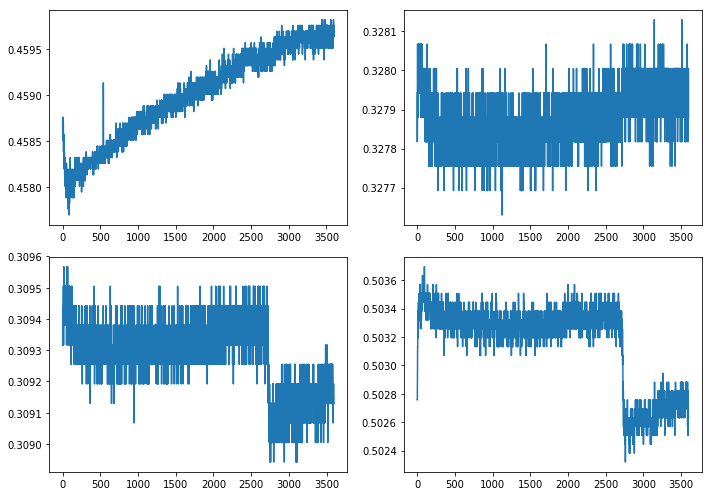

In [68]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,7))

led = 'uv'
config['tmp_dir']='/home/combet/tmp_9rafts/60x60/'
bb = pkl.load(open(config['tmp_dir']+'/beam_object_'+ref_raft+'_'+ref_slot+'_'+led+'_'+baffle+'.pkl','rb'))
axes[0][0].plot(bb.raw_data['pd_value'], label='uv')

led = 'red'
config['tmp_dir']='/home/combet/tmp_9rafts/60x60/'
bb = pkl.load(open(config['tmp_dir']+'/beam_object_'+ref_raft+'_'+ref_slot+'_'+led+'_'+baffle+'.pkl','rb'))
axes[0][1].plot(bb.raw_data['pd_value'], label='red')

led = 'nm850'
config['tmp_dir']='/home/combet/tmp_9rafts/60x60/'
bb = pkl.load(open(config['tmp_dir']+'/beam_object_'+ref_raft+'_'+ref_slot+'_'+led+'_'+baffle+'.pkl','rb'))
axes[1][0].plot(bb.raw_data['pd_value'], label='nm850')


led = 'nm960'
config['tmp_dir']='/home/combet/tmp_9rafts/60x60/'
bb = pkl.load(open(config['tmp_dir']+'/beam_object_'+ref_raft+'_'+ref_slot+'_'+led+'_'+baffle+'.pkl','rb'))
axes[1][1].plot(bb.raw_data['pd_value'], label='nm960')
fig.tight_layout()

In [24]:
r1

array([5.78173937e-06, 5.78173937e-06, 5.78173937e-06, ...,
       5.78173937e-06, 5.78173937e-06, 5.78173937e-06])

In [99]:
bb.interp_beam_BOT(amp=5, pd_corr=True)

In [52]:
im = bb.make_image_BOT()

In [53]:
bb.find_max()

In [54]:
bb.properties

{'ref_raft': 'R22',
 'ref_slot': 'S11',
 'ref_amp': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 'ref_pix_x': 1000,
 'ref_pix_y': 256,
 'npix_for_avg': 30,
 'analysis_amp': 5,
 'ncols': 300,
 'nrows': 300,
 'max_xccob': 3.192257525083612,
 'max_yccob': 6.444598662207355,
 'max_xarg': 124,
 'max_yarg': 164}

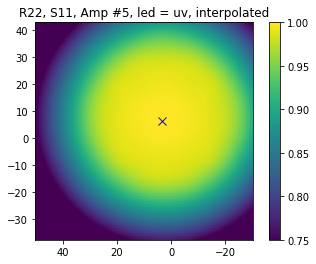

In [62]:
binsize_y = (max(bb.beam_image['yarr'])-min(bb.beam_image['yarr']))/len(im[0])
binsize_x = (max(bb.beam_image['xarr'])-min(bb.beam_image['xarr']))/len(im[1])
extent = [max(bb.beam_image['xarr'])+binsize_x/2,
          min(bb.beam_image['xarr'])-binsize_x/2,
          min(bb.beam_image['yarr'])-binsize_y/2, 
          max(bb.beam_image['yarr'])+binsize_y/2]

plt.imshow(np.flip(im, axis=1)/np.max(im.flatten()), extent=extent, 
           origin='lower', vmin=0.75)
#plt.imshow(im, extent=extent, origin='lower')
plt.colorbar()
plt.title(ref_raft+', '+ref_slot+', Amp #'+str(amp)+', led = '+led+', interpolated')
plt.plot([bb.properties['max_xccob']], [bb.properties['max_yccob']], marker='x', markersize=8, color='blue')
basename = ref_raft+'_'+ref_slot+'_'+str(amp)+'_'+baffle
plt.savefig(config['tmp_dir']+'/beam_'+basename+'_'+led+'_model_norm.png')

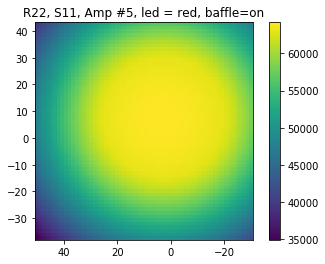

In [167]:
config['tmp_dir']='/home/combet/tmp_9rafts/60x60/'
ref_raft='R22'
ref_slot='S11'
baffle='on'
led = 'red'
bb = pkl.load(open(config['tmp_dir']+'beam_object_'+ref_raft+'_'+ref_slot+'_'+led+'_'+baffle+'.pkl','rb'))

amp=5 # 1-16, select the channel used for the reconstruction

binsize = (max(bb.raw_data['yarr'])-min(bb.raw_data['yarr']))/59
extent = [max(bb.raw_data['xarr'])+binsize/2,
          min(bb.raw_data['xarr'])-binsize/2,
          min(bb.raw_data['yarr'])-binsize/2, 
          max(bb.raw_data['yarr'])+binsize/2]

tmp = np.asarray(bb.raw_data['val'][amp])#/np.asarray(bb.raw_data['pd_value']) # correct for the control photodiode value
#tmp = tmp / max(tmp) # normalise to the max

plt.imshow(np.flip(np.reshape(tmp,(60,60)),axis=1), extent=extent, origin='lower')
plt.title(ref_raft+', '+ref_slot+', Amp #'+str(amp)+', led = '+led+', baffle='+baffle)
plt.colorbar()
basename = ref_raft+'_'+ref_slot+'_'+str(amp)+'_'+baffle
plt.savefig(config['tmp_dir']+'/beam_'+basename+'_'+led+'.png')

# plt.imshow(np.flip(np.reshape(tmp2,(12,12)),axis=1), extent=extent, origin='lower', vmin=0.75)
# plt.title(ref_raft+', '+ref_slot+', Amp #'+str(amp)+', led = '+led+', baffle='+baffle)
# plt.colorbar()
# basename = ref_raft+'_'+ref_slot+'_'+str(amp)+'_'+baffle
# plt.savefig(config['tmp_dir']+'/beam_'+basename+'_'+led+'_norm.png')


In [168]:
bb.interp_beam_BOT(amp=5, pd_corr=True)
im = bb.make_image_BOT(ncols=4000, nrows=4000)
bb.find_max()
bb.properties

{'ref_raft': 'R22',
 'ref_slot': 'S11',
 'ref_amp': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 'ref_pix_x': 1000,
 'ref_pix_y': 256,
 'npix_for_avg': 30,
 'analysis_amp': 5,
 'ncols': 4000,
 'nrows': 4000,
 'max_xccob': 4.983742185546383,
 'max_yccob': 7.37620280070017,
 'max_xarg': 1748,
 'max_yarg': 2240}

In [169]:
bb.find_max_from_avg()
bb.properties

{'ref_raft': 'R22',
 'ref_slot': 'S11',
 'ref_amp': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 'ref_pix_x': 1000,
 'ref_pix_y': 256,
 'npix_for_avg': 30,
 'analysis_amp': 5,
 'ncols': 4000,
 'nrows': 4000,
 'max_xccob': 3.103272068017006,
 'max_yccob': 7.456222805701422,
 'max_xarg': 1654,
 'max_yarg': 2244}

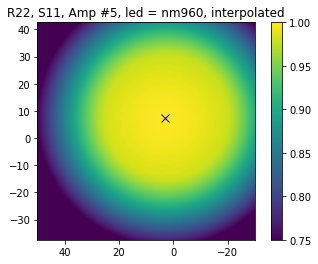

In [163]:
binsize_y = (max(bb.beam_image['yarr'])-min(bb.beam_image['yarr']))/len(im[0])
binsize_x = (max(bb.beam_image['xarr'])-min(bb.beam_image['xarr']))/len(im[1])
extent = [max(bb.beam_image['xarr'])+binsize_x/2,
          min(bb.beam_image['xarr'])-binsize_x/2,
          min(bb.beam_image['yarr'])-binsize_y/2, 
          max(bb.beam_image['yarr'])+binsize_y/2]

plt.imshow(np.flip(im, axis=1)/np.max(im.flatten()), extent=extent, 
           origin='lower', vmin=0.75)
#plt.imshow(im, extent=extent, origin='lower')
plt.colorbar()
plt.title(ref_raft+', '+ref_slot+', Amp #'+str(amp)+', led = '+led+', interpolated')
plt.plot([bb.properties['max_xccob']], [bb.properties['max_yccob']], marker='x', markersize=8, color='blue')
basename = ref_raft+'_'+ref_slot+'_'+str(amp)+'_'+baffle
plt.savefig(config['tmp_dir']+'/beam_'+basename+'_'+led+'_model_norm.png')

In [5]:
import pickle as pkl
config['tmp_dir']='/home/combet/tmp_9rafts/60x60/'
ref_raft='R22'
ref_slot='S11'
baffle='on'
led = 'red'
bb = pkl.load(open(config['tmp_dir']+'beam_object_'+ref_raft+'_'+ref_slot+'_'+led+'_'+baffle+'.pkl','rb'))

amp=5 # 1-16, select the channel used for the reconstruction

binsize = (max(bb.raw_data['yarr'])-min(bb.raw_data['yarr']))/59
extent = [max(bb.raw_data['xarr'])+binsize/2,
          min(bb.raw_data['xarr'])-binsize/2,
          min(bb.raw_data['yarr'])-binsize/2, 
          max(bb.raw_data['yarr'])+binsize/2]

tmp = np.asarray(bb.raw_data['val'][amp])#/np.asarray(bb.raw_data['pd_value']) # correct for the control photodiode value
#tmp = tmp / max(tmp) # normalise to the max

plt.imshow(np.flip(np.reshape(tmp,(60,60)),axis=1), extent=extent, origin='lower')
plt.title(ref_raft+', '+ref_slot+', Amp #'+str(amp)+', led = '+led+', baffle='+baffle)
plt.colorbar()
basename = ref_raft+'_'+ref_slot+'_'+str(amp)+'_'+baffle
plt.savefig(config['tmp_dir']+'/beam_'+basename+'_'+led+'.png')



In [121]:
import pickle as pkl
config['tmp_dir']='/home/combet/tmp_9rafts/12x12/'
ref_raft = 'R22'
leds = ['nm960', 'nm850', 'nm750', 'red', 'blue', 'uv']
ref_slot = 'S11'
amp = 5
baffle='on'
#led = b.config['led_name']
bb_ref = pkl.load(open(config['tmp_dir']+'beam_object_'+ref_raft+'_'+ref_slot+'_red_'+baffle+'.pkl','rb'))
tmp_ref = np.asarray(bb_ref.raw_data['val'][amp])/np.asarray(bb_ref.raw_data['pd_value']) # correct for the control photodiode value
tmp_ref = tmp_ref / max(tmp_ref)

for led in leds:
    bb = pkl.load(open(config['tmp_dir']+'beam_object_'+ref_raft+'_'+ref_slot+'_'+led+'_'+baffle+'.pkl','rb'))
       
    binsize = (max(bb.raw_data['yarr'])-min(bb.raw_data['yarr']))/11
    extent = [max(bb.raw_data['xarr'])+binsize/2,
              min(bb.raw_data['xarr'])-binsize/2,
              min(bb.raw_data['yarr'])-binsize/2, 
              max(bb.raw_data['yarr'])+binsize/2]

    tmp = np.asarray(bb.raw_data['val'][amp])/np.asarray(bb.raw_data['pd_value']) # correct for the control photodiode value
    tmp = tmp / max(tmp) # normalise to the max

    plt.imshow(np.flip(np.reshape(tmp/tmp_ref,(12,12)).T,axis=1), extent=extent, origin='lower')
    plt.title(ref_raft+', '+ref_slot+', Amp #'+str(amp)+', led = '+led+', baffle='+baffle)
    plt.colorbar()
    basename = ref_raft+'_'+ref_slot+'_'+str(amp)+'_'+baffle
    plt.savefig(config['tmp_dir']+'/beam_'+basename+'_'+led+'_ratio_to_red.png')
    plt.close()